In [2]:
import sys
print(sys.path)

['/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python310.zip', '/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python3.10', '/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python3.10/lib-dynload', '', '/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python3.10/site-packages']


In [3]:
from fastbook import *
from fastai.vision.widgets import *

import dotenv

In [5]:
# expecting AZURE_SEARCH_KEY=<key> in .env file
dotenv.load_dotenv('.env')
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')
print('successfully fetched env vars')

successfully fetched env vars


In [6]:
comic_collections = ['the far side', 'xkcd', 'dilbert', 'pearls before swine', 'rhymes with orange', 'hägar the horrible', 'in the bleachers']
path = Path('comics')

In [10]:
if path.exists():
    print(f'{os.path.abspath(path)} exists. Skipping downloading of images.')
else:
    path.mkdir()
    for c in comic_collections:
        print(f'searching for "{c}" comics...')
        dest = (path/c)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{c} comics')
        print(f'downloading "{c}" comics...')
        download_images(dest, urls=results.attrgot('contentUrl'))
        print('done.')

/Users/martin/vscode/fastbook/clean/comics exists. Skipping downloading of images.


In [12]:
files = get_image_files(path)
print(f'{len(files)} attempted downloads')

931 attempted downloads


In [15]:
failed = verify_images(files)
print(f'{len(failed)} failed downloads')

35 failed downloads


In [16]:
print('cleaning up failed downloads...')
failed.map(Path.unlink);
print('done.')

cleaning up failed downloads...
done.


In [29]:
comics = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256)
)

In [30]:
dls = comics.dataloaders(path)

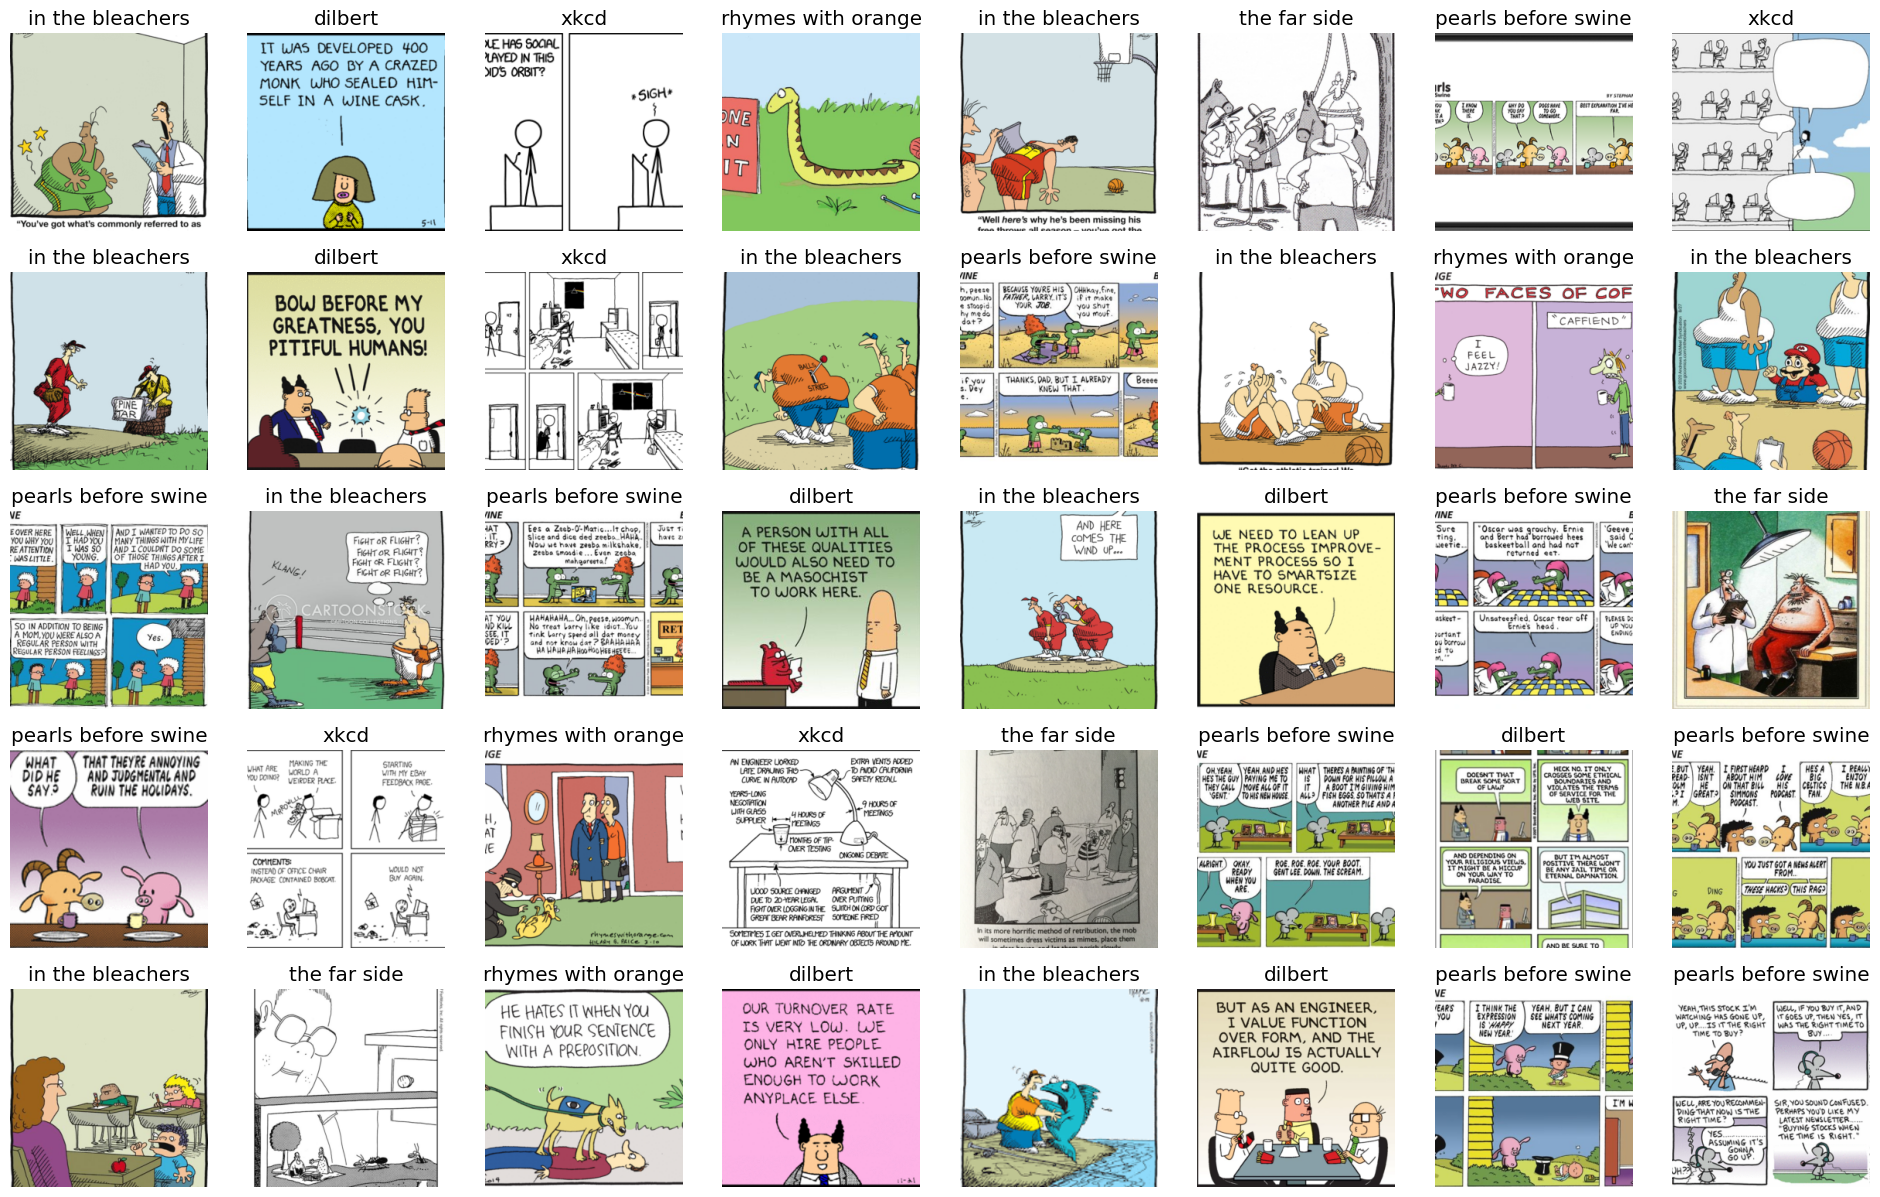

In [31]:
dls.valid.show_batch(max_n=40, nrows=5)

In [28]:
comics = comics.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = comics.dataloaders(path)
dls.train.show_batch(max_n=40, nrows=5, unique=True)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## Training Your Model, and Using It to Clean Your Data

In [32]:
comics = comics.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = comics.dataloaders(path)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [33]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.124156,0.653363,0.223464,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.660721,0.332295,0.100559,00:25
1,0.476341,0.183489,0.067039,00:25
2,0.339810,0.177677,0.083799,00:24
3,0.261317,0.179430,0.083799,00:23


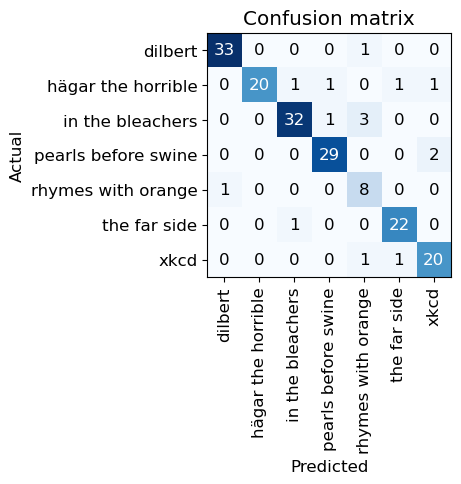

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

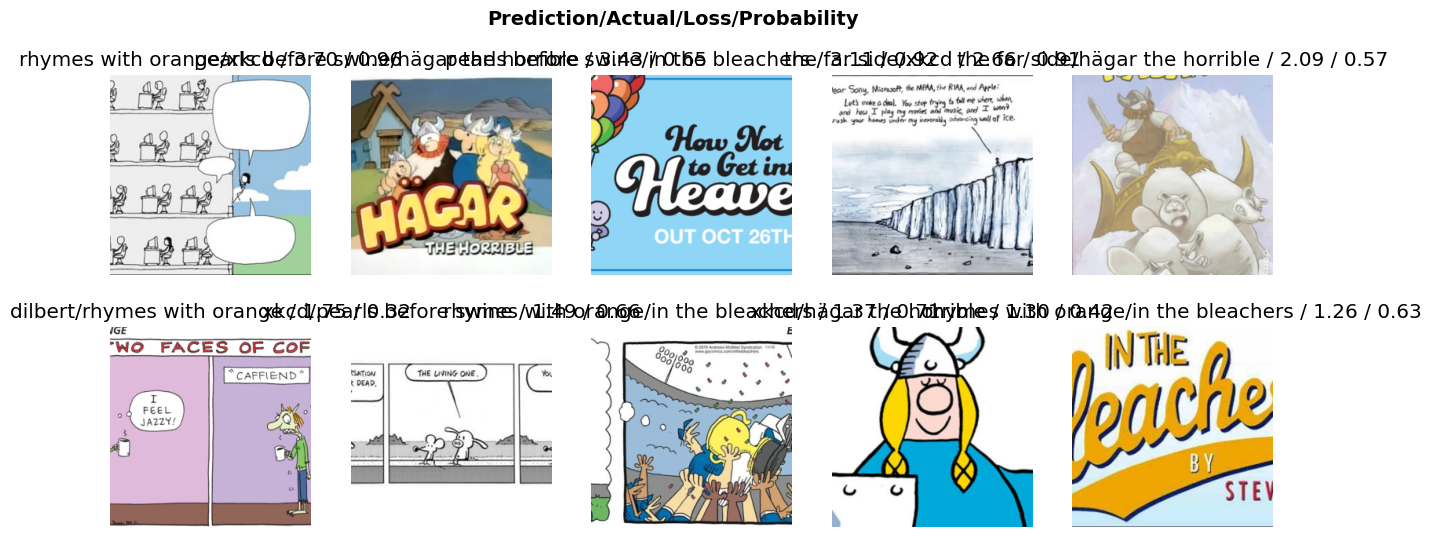

In [36]:
interp.plot_top_losses(10, nrows=2)

In [37]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')